In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("../data/processed/cleaned_data.csv")

df.head()

,Series,Contestant,score_ep1,ppt_ep1,score_ep2,ppt_ep2,final_pct_points
0,1,Frank Skinner,19,3.8,28,2.8,0.2133
1,1,Josh Widdicombe,13,2.6,29,2.9,0.2156
2,1,Roisin Conaty,7,1.4,28,2.8,0.1560
3,1,Romesh Ranganathan,19,3.8,33,3.3,0.2133
4,1,Tim Key,17,3.4,35,3.5,0.2018


In [6]:
# define two feature lists (predictive variables) and keep everything else identical

features_ep1 = [
    "score_ep1",
    "ppt_ep1"]

features_ep2 = [
    "score_ep1",
    "ppt_ep1",
    "score_ep2",
    "ppt_ep2"]

target = "final_pct_points"
groups = df["Series"]

In [7]:
# Same group split as before

gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42)

train_idx, test_idx = next(gss.split(df, df[target], groups))


In [8]:
# Create a function to train and evaulate the model to avoid duplicated code
# works the same as in prev Notebooks

def train_and_evaluate(features):
    X_train = df.loc[train_idx, features]
    X_test = df.loc[test_idx, features]

    y_train = df.loc[train_idx, target]
    y_test = df.loc[test_idx, target]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return {
        "features": features,
        "mae": mae,
        "rmse": rmse,
        "model": model,
        "y_test": y_test,
        "y_pred": y_pred}



In [9]:
# Train model on both datasets
results_ep1 = train_and_evaluate(features_ep1)
results_ep2 = train_and_evaluate(features_ep2)


In [11]:
# Compare performance
comparison = pd.DataFrame({
    "Model": ["Episode 1 only", "Episode 1 + Episode 2"],
    "MAE": [results_ep1["mae"], results_ep2["mae"]],
    "RMSE": [results_ep1["rmse"], results_ep2["rmse"]]
})

comparison

,Model,MAE,RMSE
0,Episode 1 only,0.010649,0.013518
1,Episode 1 + Episode 2,0.011558,0.014849


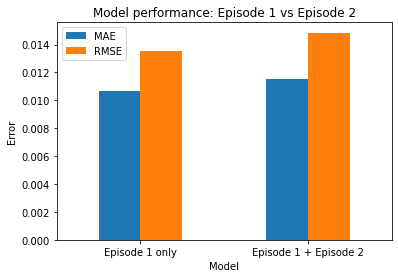

In [12]:
# Visualise the difference in model performance

comparison.set_index("Model")[["MAE", "RMSE"]].plot(kind="bar")
plt.title("Model performance: Episode 1 vs Episode 2")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()


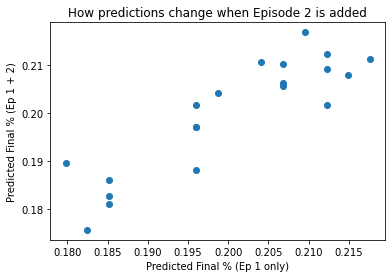

In [13]:
# How predictions change when Episode 2 is added

plt.scatter(
    results_ep1["y_pred"],
    results_ep2["y_pred"])

plt.xlabel("Predicted Final % (Ep 1 only)")
plt.ylabel("Predicted Final % (Ep 1 + 2)")
plt.title("How predictions change when Episode 2 is added")
plt.show()


In [14]:
# Coefficients

coef_ep2 = pd.DataFrame({
    "Feature": features_ep2,
    "Coefficient": results_ep2["model"].coef_
})

coef_ep2


,Feature,Coefficient
0,score_ep1,0.000965
1,ppt_ep1,0.000193
2,score_ep2,-0.000145
3,ppt_ep2,0.016490
